In [1]:
!git clone https://github.com/Hardik357/python-youtube-code.git
%cd python-youtube-code/
%cd predicting-tesla-stock-price/

Cloning into 'python-youtube-code'...
remote: Enumerating objects: 20239, done.
remote: Total 20239 (delta 0), reused 0 (delta 0), pack-reused 20239
Receiving objects: 100% (20239/20239), 195.70 MiB | 33.00 MiB/s, done.
Resolving deltas: 100% (378/378), done.
/content/python-youtube-code
/content/python-youtube-code/predicting-tesla-stock-price


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

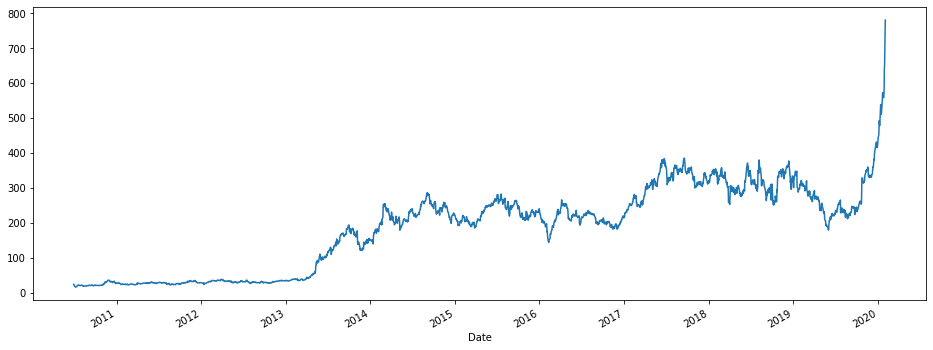

In [3]:
tesla = pd.read_csv('/content/python-youtube-code/predicting-tesla-stock-price/TSLA.csv')
tesla = tesla[['Date','Close']]

tesla.Date = pd.to_datetime(tesla.Date, format = '%Y/%m/%d')
plot_tesla = tesla.set_index('Date')
plot_tesla['Close'].plot(figsize=(16,6))

In [4]:
tesla = tesla.loc[884:1639]
tesla.head()

,Date,Close
884,2014-01-02,150.100006
885,2014-01-03,149.559998
886,2014-01-06,147.000000
887,2014-01-07,149.360001
888,2014-01-08,151.279999


In [5]:
new_tesla = tesla.drop('Date', axis=1)
new_tesla = new_tesla.reset_index(drop=True)
T = new_tesla.values
T = T.astype('float32')
T = np.reshape(T, (-1, 1))

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
T = scaler.fit_transform(T)

train_size = int(len(T) * 0.8)
test_size = int(len(T) - train_size)
train, test = T[0: train_size,:], T[train_size: len(T):]

In [7]:
def create_features(data, window_size):
    X, y = [],[]
    for i in range(len(data)-window_size - 1):
        window = data[i:(i+window_size), 0]
        X.append(window)
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

window_size = 20
X_train, y_train = create_features(train, window_size)
X_test, y_test = create_features(train, window_size)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [8]:
T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

def is_leak(T_shape, test_shape, train_shape):
    return not(T_shape[0] == train_shape[0] + test_shape[0])

print(is_leak(T_shape, test_shape, train_shape))

False


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
tf.random.set_seed(11)
np.random.seed(11)

In [11]:
model = keras.Sequential()
model.add(layers.LSTM(units=50, activation='relu', input_shape=(X_train.shape[0], window_size)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

In [12]:
from keras.callbacks import ModelCheckpoint
filepath = 'saved_models/model_epoch_{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only = True,
                             mode='min')
history = model.fit(X_train, y_train, epochs=100, batch_size=20,validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=1, shuffle=False)

Epoch 1/100
30/30 [==============================] - 2s 12ms/step - loss: 0.2663 - val_loss: 0.0577

Epoch 00001: val_loss improved from inf to 0.05774, saving model to saved_models/model_epoch_01.hdf5
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0312 - val_loss: 0.0128

Epoch 00002: val_loss improved from 0.05774 to 0.01284, saving model to saved_models/model_epoch_02.hdf5
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0202 - val_loss: 0.0121

Epoch 00003: val_loss improved from 0.01284 to 0.01210, saving model to saved_models/model_epoch_03.hdf5
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0195 - val_loss: 0.0110

Epoch 00004: val_loss improved from 0.01210 to 0.01097, saving model to saved_models/model_epoch_04.hdf5
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0106

Epoch 00005: val_loss improved from 0.01097 to 0.01055, saving model to saved_model

In [13]:
from keras.models import load_model
best_model = load_model('saved_models/model_epoch_89.hdf5')

train_predict = best_model.predict(X_train)
y_hat_train = scaler.inverse_transform(train_predict)
test_predict = best_model.predict(X_test)
y_hat_test = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
y_train = scaler.inverse_transform([y_train])